# Importing Important Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch
from evaluate import load
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from datasets import Dataset
from torch.optim import AdamW
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Load the dataset

In [ ]:
# Load the dataset
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Posts preprocessing

In [ ]:
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Apply the function to 'Question_body' column
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)


# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())

                                       Question_body  \
0  <p>When deploying a Windows EC2 instance with ...   
1  I'm pretty new to my company (2 weeks) and we'...   
2  <p>I am trying to figure out how to get <code>...   
3  Say you have an application divided into 3-tie...   
4  <p>I am trying to use the circuit breaker patt...   

                               Question_body_cleaned  
0  When deploying a Windows EC2 instance with Ter...  
1  I'm pretty new to my company (2 weeks) and we'...  
2  I am trying to figure out how to get [code-sni...  
3  Say you have an application divided into 3-tie...  
4  I am trying to use the circuit breaker pattern...  


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)

    # Tokenize text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

dataset['Question_body_cleaned'] = dataset['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)

# Load the BERT tokenizer and model

In [ ]:
# Load Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Enable GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Tokenization function
def tokenize_function(dataset):
    tokens = tokenizer(
        dataset['Question_body_preprocessed'],
        padding='max_length',
        truncation=True,
        max_length=64  # Reduced from 128
    )
    tokens["labels"] = dataset["labels"]
    return tokens

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Split the dataset

In [ ]:
# Split dataset
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

# Ensure labels are integers
train_df['labels'] = train_df['Label'].astype(int)
test_df['labels'] = test_df['Label'].astype(int)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Filter out any problematic rows
train_dataset = train_dataset.filter(lambda x: isinstance(x['Question_body_preprocessed'], str))
test_dataset = test_dataset.filter(lambda x: isinstance(x['Question_body_preprocessed'], str))

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Speed up data loading
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Filter:   0%|          | 0/11945 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2987 [00:00<?, ? examples/s]

Map:   0%|          | 0/11945 [00:00<?, ? examples/s]

Map:   0%|          | 0/2987 [00:00<?, ? examples/s]

# Define Training Arguments

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    max_grad_norm=1.0,
    gradient_accumulation_steps=2,
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    report_to="none",
    fp16=True
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



# Define Trainer

In [ ]:
# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator
)

# Train the BERT Model

In [ ]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.393900,0.371393
2,0.221900,0.169353


TrainOutput(global_step=279, training_loss=0.34507080090088654, metrics={'train_runtime': 137.2674, 'train_samples_per_second': 261.06, 'train_steps_per_second': 2.033, 'total_flos': 1168805085672960.0, 'train_loss': 0.34507080090088654, 'epoch': 2.9732620320855614})

# Evaluate the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get model predictions
predictions = trainer.predict(test_dataset)

# Ensure the correct extraction of predictions and labels
y_pred = predictions.predictions.argmax(-1)
y_true = test_dataset["labels"]  # Ensure direct access to labels

# Compute evaluation metrics (overall metrics)
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# Print results
print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Overall Accuracy: 0.9354
Precision: 0.9494
Recall: 0.9195
F1 Score: 0.9342


## Prediction results analysis with Confusion Matrix

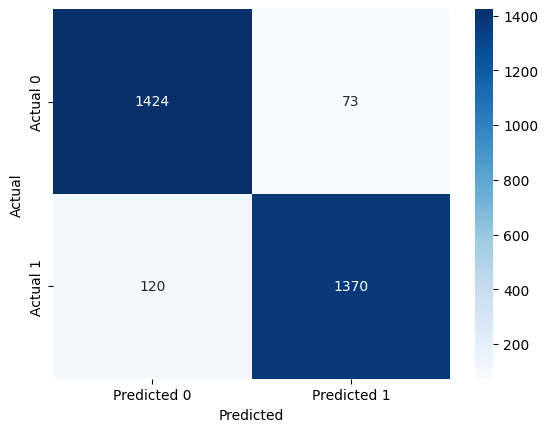

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()